In [17]:
#imports
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random


reading the dataset

In [18]:
def read_csv(file_path,has_header):
    """this function is used for taking the dataset from .csv file making a test train split
    and x, y split (has header is either True or False)"""

    #reading the .csv
    if has_header:
        df = pd.read_csv(file_path, header=0, delimiter=",")  # First row as header
        print(f"Dataset shape: {df.shape}")
        print(f"Column names: {list(df.columns)}")
    else:
        df = pd.read_csv(file_path, header=None, delimiter=",")  # No header row
        print(f"Dataset shape: {df.shape}")
    
    return df


selecting the dataset

In [19]:
df = read_csv("beans_kmeans.csv", True)
label_column = 16

Dataset shape: (13611, 17)
Column names: ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']


making string columns numeric

In [20]:
# Find all string/object columns automatically
string_columns = df.select_dtypes(include=['object']).columns

# Encode all string columns
for column in string_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])

mi for all features (graph)

In [21]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


            Feature  MI_Score
1         Perimeter  1.005183
7     EquivDiameter  0.968320
2   MajorAxisLength  0.954053
6        ConvexArea  0.942731
0              Area  0.930840
13     ShapeFactor2  0.921788
12     ShapeFactor1  0.895537
3   MinorAxisLength  0.872991
11      Compactness  0.810451
14     ShapeFactor3  0.808186
4      AspectRation  0.797310
5      Eccentricity  0.783563
10        roundness  0.767800
15     ShapeFactor4  0.338329
9          Solidity  0.223004
8            Extent  0.193118


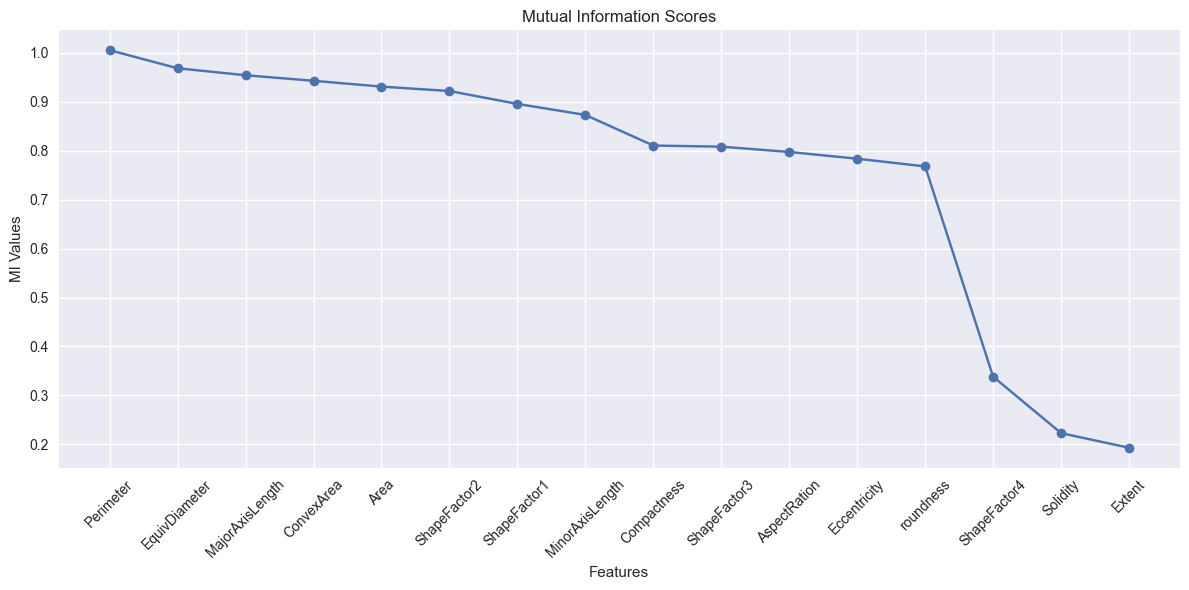

In [22]:
def mi_for_all(df_name = df, lc = label_column):
    y = df_name.iloc[:, lc]
    x = df_name.drop(df_name.columns[lc], axis=1)
    mi_scores = mutual_info_classif(x, y, discrete_features=True)
    mi_df = pd.DataFrame({"Feature": x.columns, "MI_Score": mi_scores}).sort_values(by="MI_Score", ascending=False)
    print(mi_df)

    # Create line plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(mi_df["Feature"], mi_df["MI_Score"], marker='o')
    ax.set_xlabel("Features")
    ax.set_ylabel("MI Values")
    ax.set_title("Mutual Information Scores")
    plt.style.use('seaborn-v0_8')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return x,y,mi_df

x,y,mi_df= mi_for_all()



vertical split

In [ ]:
# Target columns count (divide into 3 parts, take integer)
total_columns = df.shape[1]
target_columns_count = total_columns // 3

# Pick random feature columns from total number of columns from dataset x
random.seed(42)
random_cols = random.sample(range(x.shape[1]), target_columns_count - 1)

# Build target_set (label first, then random features)
target_features = x.iloc[:, random_cols]
target_set = pd.concat([y, target_features], axis=1)

remaining_set = x.drop(x.columns[random_cols], axis=1)


print("Target columns count:", target_columns_count)
print("Selected feature indices:", random_cols)


print(target_set.head(), "\n")
print(remaining_set.head())


mi on the set with label to find the target (lowest mi)

In [ ]:
# Get MI scores and find lowest MI column
x,y,mi_df = mi_for_all(df_name=target_set, lc=0)
lowest_mi_column = mi_df.iloc[-1]['Feature']
print(f"Column with lowest MI: {lowest_mi_column}")

# Calculate Spearman correlations
lowest_mi_data = target_set[lowest_mi_column]
correlations = remaining_set.corrwith(lowest_mi_data, method='spearman')

# Convert to DataFrame and sort
corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Spearman_Correlation': correlations.abs().values
}).sort_values('Spearman_Correlation', ascending=False)

print(f"Spearman correlations between '{lowest_mi_column}' and remaining_set:")
print(corr_df)

# Create line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(corr_df["Feature"], corr_df["Spearman_Correlation"], marker='o')
ax.set_xlabel("Features")
ax.set_ylabel("Abs. Corrolation Values")
ax.set_title("Feature Corrolations")
plt.style.use('seaborn-v0_8')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

spearman with target to varibales that are outside the set (graph to see elbow)